In [1]:
import tensorflow_addons as tfa

from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess
from sklearn.metrics import f1_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed'
)

In [3]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

In [4]:
n_neurons: int = 1024
n_features: int = len(train_x.columns)

In [5]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [6]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [7]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [8]:
with tf.device('/gpu:0'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=early_stopping_patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)

    model.add(tfa.layers.ESN(n_neurons,
                             return_sequences=True,
                             input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(tf.keras.layers.Dense(n_y,
                                    activation=tf.keras.activations.softmax))

    model.summary()
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    history = model.fit(x=train_x,
                        y=train_y,
                        epochs=epochs,
                        validation_data=(val_x, val_y),
                        callbacks=[early_stopping],
                        batch_size=batch_size)
    predict = model.predict(test_x)

Metal device set to: Apple M1 Pro


2022-06-24 10:47:19.538031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-24 10:47:19.538145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-24 10:47:19.612204: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-24 10:47:19.665288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 10:47:19.681620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 172)        345       
 n)                                                              
                                                                 
 esn (ESN)                   (None, None, 1024)        1225728   
                                                                 
 dense (Dense)               (None, None, 7)           7175      
                                                                 
Total params: 1,233,248
Trainable params: 7,175
Non-trainable params: 1,226,073
_________________________________________________________________
Epoch 1/100
  4/679 [..............................] - ETA: 14s - loss: 2.1773 

2022-06-24 10:47:40.874914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


678/679 [============================>.] - ETA: 0s - loss: 0.9493

2022-06-24 10:47:52.708538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


679/679 [==============================] - 14s 19ms/step - loss: 0.9489 - val_loss: 0.9306
Epoch 2/100
679/679 [==============================] - 13s 19ms/step - loss: 0.7015 - val_loss: 0.8666
Epoch 3/100
679/679 [==============================] - 13s 19ms/step - loss: 0.6488 - val_loss: 0.8527
Epoch 4/100
679/679 [==============================] - 13s 19ms/step - loss: 0.6180 - val_loss: 0.8319
Epoch 5/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5973 - val_loss: 0.8121
Epoch 6/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5828 - val_loss: 0.8135
Epoch 7/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5713 - val_loss: 0.8096
Epoch 8/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5637 - val_loss: 0.8130
Epoch 9/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5570 - val_loss: 0.7998
Epoch 10/100
679/679 [==============================] - 13s 19ms/step - loss: 0.5521 

2022-06-24 10:50:54.978416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 3s 13ms/step


In [9]:
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [10]:
f1_score(gold_labels, predicted_labels, average='weighted')

0.7403335536678569

In [11]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 425,    2,   40,   14,   39,    0,    0],
       [   5, 1771,  253,   11,   18,    0,    1],
       [  15,  138, 2189,   82,  144,    0,    9],
       [  10,   74,  374,   86,  100,    0,    0],
       [   4,    8,  119,   26,  262,    1,    1],
       [   3,    0,    1,    6,    2,    5,    0],
       [   2,    0,   14,    3,   14,    0,   24]], dtype=int32)>

In [ ]:
export_dir: str = 'Plots/ESN'

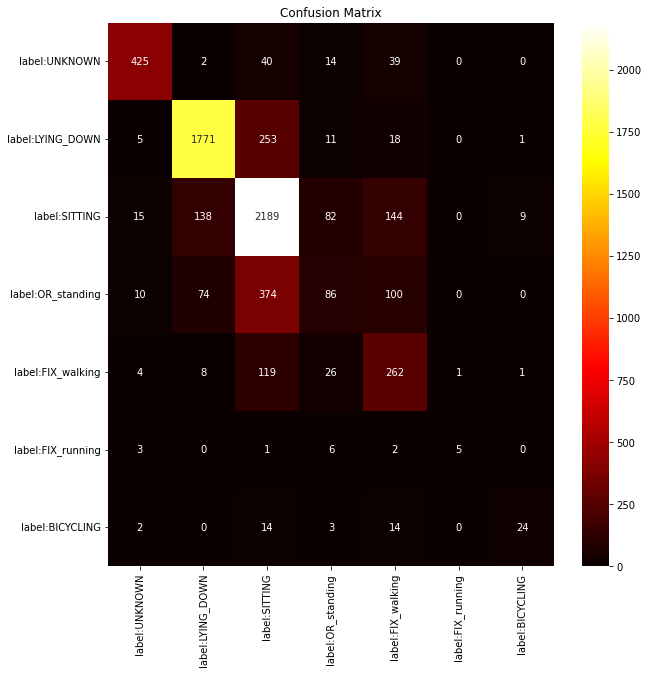

In [12]:
plot_conf_matrix(gold_labels, predicted_labels, export_dir=export_dir)

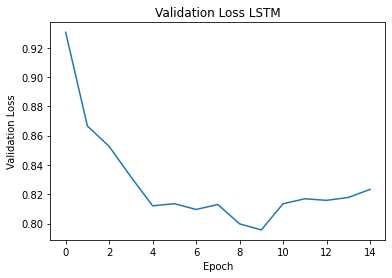

In [13]:
plot_val_loss_progress(history, export_dir=export_dir)